In [72]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math


from pyvrp import Model, Solution
from pyvrp.plotting import plot_coordinates, plot_solution
from pyvrp.stop import MaxRuntime

In [73]:

COORDS = [
    (456, 320),  # location 0 - the depot
    (228, 0),    # location 1
    (912, 0),    # location 2
    (0, 80),     # location 3
    (67, 24),    # location 4
    (234, 145),  # location 5
    (113, 221),  # location 6
    (380, 200)   # location 7
    ]
DEMANDS = [
    (0, 0),   # location 0 - a depot
    (1, 4),   # location 1 - simultaneous pickup and delivery
    (2, 0),   # location 2 - pure delivery
    (0, 5),   # location 3 - pure pickup
    (6, 3),   # location 4 - simultaneous pickup and delivery
    (4, 7),   # location 5 - simultaneous pickup and delivery
    (11, 0),  # location 6 - pure delivery
    (3, 0),   # location 7 - pure delivery
]



In [74]:

DURATION_MATRIX = [
        [0, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0]
]
TIME_WINDOWS = [
        (8, 16),  # location 0 - the depot (modified to be unrestricted)
        (8, 12),   # location 1
        (12, 14),  # location 2
        (14, 16),  # location 3
        (8, 10),   # location 4
        (10, 12),  # location 5
        (12, 14),  # location 6
        (14, 16)   # location 7
]



In [75]:
Number_of_vehicles = 1
Vehicle_capacity = 100
service_time = 0


In [76]:
m = Model()
m.add_vehicle_type(
    Number_of_vehicles,
    capacity=Vehicle_capacity,
    max_duration=24,
    tw_early=TIME_WINDOWS[0][0],
    tw_late=TIME_WINDOWS[0][1],
)

depot = m.add_depot(x=COORDS[0][0], y=COORDS[0][1])
clients = [
    m.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        delivery=DEMANDS[idx][0],
        pickup=DEMANDS[idx][1],
        service_duration=service_time,
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )
    for idx in range(1, len(COORDS))
]

locations = [depot] + clients
distance_matrix = [[0] * len(locations) for _ in range(len(locations))]


for frm_idx, frm in enumerate(locations):
    for to_idx, to in enumerate(locations):
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        duration = DURATION_MATRIX[frm_idx][to_idx]
        m.add_edge(frm, to, distance=distance, duration=duration)
        distance_matrix[frm_idx][to_idx] = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan distance


d = distance_matrix[0][1:]


In [77]:
res = m.solve(stop=MaxRuntime(5), display=True) 
print(res)

PyVRP v0.10.1

Solving an instance with:
    1 depot
    7 clients
    1 vehicle (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      0s |  33     3782     3778 |  54     4105     3565
     1000      1s |  63     3780     3778 |  62     4040     3565
     1500      1s |  60     3780     3778 |  29     4546     3565
     2000      2s |  58     3781     3778 |  37     3705     3133
     2500      2s |  45     3781     3778 |  45     3617     3133
     3000      2s |  34     3782     3778 |  53     3552     3133
     3500      3s |  59     3781     3778 |  61     3496     3133
     4000      3s |  29     3783     3778 |  28     3634     2944
     4500      4s |  36     3782     3778 |  36     3488     2952
     5000      4s |  29     3783     3778 |  44     3390     2952
     5500      4s |  30     3783     3778 |  52     3323     2952
     6000      5s |  53     3781     3778 |  60  

In [78]:
Solution_ = res.best
Routes_ = Solution_.routes()
Cost_ = res.cost()

print(Solution_)
print(Routes_[0])
print(Cost_)

Route #1: 4 5 1 2 6 3 7 

4 5 1 2 6 3 7 
3778


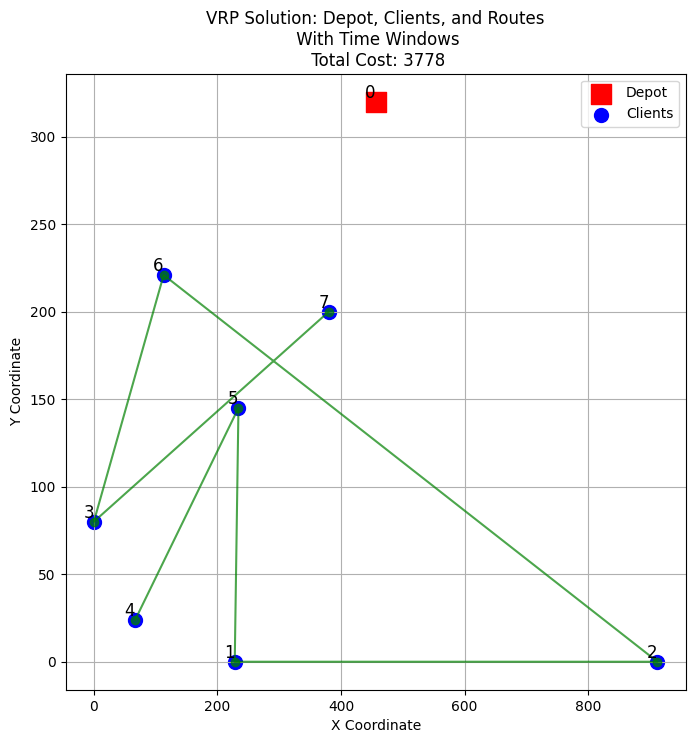

In [79]:
# Extract coordinates
x_coords, y_coords = zip(*COORDS)

# Plot depot and clients
plt.figure(figsize=(8, 8))
plt.scatter(x_coords[0], y_coords[0], c='red', marker='s', s=200, label="Depot")  # Depot in red square
plt.scatter(x_coords[1:], y_coords[1:], c='blue', marker='o', s=100, label="Clients")  # Clients in blue circles

# Annotate points with their index
for idx, (x, y) in enumerate(COORDS):
    plt.text(x, y, str(idx), fontsize=12, ha='right', va='bottom', color="black")

# Plot routes
for route in Routes_:
    route_coords = [COORDS[loc] for loc in route]
    x_route, y_route = zip(*route_coords)
    plt.plot(x_route, y_route, linestyle='-', marker='o', color='green', alpha=0.7)

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.title(f"VRP Solution: Depot, Clients, and Routes\n With Time Windows\n Total Cost: {Cost_}")
plt.grid(True)
plt.show()


In [80]:
customers = set(range(1, len(COORDS)))

In [81]:
def all_subsets(s):
    s = list(s)
    return [set(combo) for r in range(len(s)+1) for combo in itertools.combinations(s, r)]

print(all_subsets(customers))


[set(), {1}, {2}, {3}, {4}, {5}, {6}, {7}, {1, 2}, {1, 3}, {1, 4}, {1, 5}, {1, 6}, {1, 7}, {2, 3}, {2, 4}, {2, 5}, {2, 6}, {2, 7}, {3, 4}, {3, 5}, {3, 6}, {3, 7}, {4, 5}, {4, 6}, {4, 7}, {5, 6}, {5, 7}, {6, 7}, {1, 2, 3}, {1, 2, 4}, {1, 2, 5}, {1, 2, 6}, {1, 2, 7}, {1, 3, 4}, {1, 3, 5}, {1, 3, 6}, {1, 3, 7}, {1, 4, 5}, {1, 4, 6}, {1, 4, 7}, {1, 5, 6}, {1, 5, 7}, {1, 6, 7}, {2, 3, 4}, {2, 3, 5}, {2, 3, 6}, {2, 3, 7}, {2, 4, 5}, {2, 4, 6}, {2, 4, 7}, {2, 5, 6}, {2, 5, 7}, {2, 6, 7}, {3, 4, 5}, {3, 4, 6}, {3, 4, 7}, {3, 5, 6}, {3, 5, 7}, {3, 6, 7}, {4, 5, 6}, {4, 5, 7}, {4, 6, 7}, {5, 6, 7}, {1, 2, 3, 4}, {1, 2, 3, 5}, {1, 2, 3, 6}, {1, 2, 3, 7}, {1, 2, 4, 5}, {1, 2, 4, 6}, {1, 2, 4, 7}, {1, 2, 5, 6}, {1, 2, 5, 7}, {1, 2, 6, 7}, {1, 3, 4, 5}, {1, 3, 4, 6}, {1, 3, 4, 7}, {1, 3, 5, 6}, {1, 3, 5, 7}, {1, 3, 6, 7}, {1, 4, 5, 6}, {1, 4, 5, 7}, {1, 4, 6, 7}, {1, 5, 6, 7}, {2, 3, 4, 5}, {2, 3, 4, 6}, {2, 3, 4, 7}, {2, 3, 5, 6}, {2, 3, 5, 7}, {2, 3, 6, 7}, {2, 4, 5, 6}, {2, 4, 5, 7}, {2, 4, 6, 7}

In [82]:
def subsets_containing_client(client, coords):
    customers = set(range(1, len(coords)))  # Exclude the depot (index 0)
    all_subsets = [set(combo) for r in range(1, len(customers) + 1) for combo in itertools.combinations(customers, r)]
    return [subset for subset in all_subsets if client in subset]

# Example usage
client = 3
subsets = subsets_containing_client(client, COORDS)
print(subsets)

[{3}, {1, 3}, {2, 3}, {3, 4}, {3, 5}, {3, 6}, {3, 7}, {1, 2, 3}, {1, 3, 4}, {1, 3, 5}, {1, 3, 6}, {1, 3, 7}, {2, 3, 4}, {2, 3, 5}, {2, 3, 6}, {2, 3, 7}, {3, 4, 5}, {3, 4, 6}, {3, 4, 7}, {3, 5, 6}, {3, 5, 7}, {3, 6, 7}, {1, 2, 3, 4}, {1, 2, 3, 5}, {1, 2, 3, 6}, {1, 2, 3, 7}, {1, 3, 4, 5}, {1, 3, 4, 6}, {1, 3, 4, 7}, {1, 3, 5, 6}, {1, 3, 5, 7}, {1, 3, 6, 7}, {2, 3, 4, 5}, {2, 3, 4, 6}, {2, 3, 4, 7}, {2, 3, 5, 6}, {2, 3, 5, 7}, {2, 3, 6, 7}, {3, 4, 5, 6}, {3, 4, 5, 7}, {3, 4, 6, 7}, {3, 5, 6, 7}, {1, 2, 3, 4, 5}, {1, 2, 3, 4, 6}, {1, 2, 3, 4, 7}, {1, 2, 3, 5, 6}, {1, 2, 3, 5, 7}, {1, 2, 3, 6, 7}, {1, 3, 4, 5, 6}, {1, 3, 4, 5, 7}, {1, 3, 4, 6, 7}, {1, 3, 5, 6, 7}, {2, 3, 4, 5, 6}, {2, 3, 4, 5, 7}, {2, 3, 4, 6, 7}, {2, 3, 5, 6, 7}, {3, 4, 5, 6, 7}, {1, 2, 3, 4, 5, 6}, {1, 2, 3, 4, 5, 7}, {1, 2, 3, 4, 6, 7}, {1, 2, 3, 5, 6, 7}, {1, 3, 4, 5, 6, 7}, {2, 3, 4, 5, 6, 7}, {1, 2, 3, 4, 5, 6, 7}]


In [83]:
def relax_time_windows(time_windows_):
    time_windows__ = time_windows_.copy()
    return [(8, 18) for early, late in time_windows__]
def relax_client_time_windows(time_windows_, client):
    time_windows__ = time_windows_.copy()
    time_windows__[client] = (8, 18)
    return time_windows__
def relax_clients_time_windows(time_windows_, clients):
    time_windows__ = time_windows_.copy()
    for client in clients:
        time_windows__[client] = (8, 18)
    return time_windows__
def relax_time_windows_but_clients(time_windows_, clients):
    time_windows__ = time_windows_.copy()
    clients_ = list(set(range(len(time_windows__))) - set(clients))
    for client in clients_:
        time_windows__[client] = (8, 18)
    return time_windows__

print(TIME_WINDOWS)
print(relax_time_windows(TIME_WINDOWS))
print(relax_client_time_windows(TIME_WINDOWS, 1))
print(relax_clients_time_windows(TIME_WINDOWS, {1, 2}))

print(relax_time_windows_but_clients(TIME_WINDOWS, {1, 2}))


print(len(customers))
print(customers)

[(8, 16), (8, 12), (12, 14), (14, 16), (8, 10), (10, 12), (12, 14), (14, 16)]
[(8, 18), (8, 18), (8, 18), (8, 18), (8, 18), (8, 18), (8, 18), (8, 18)]
[(8, 16), (8, 18), (12, 14), (14, 16), (8, 10), (10, 12), (12, 14), (14, 16)]
[(8, 16), (8, 18), (8, 18), (14, 16), (8, 10), (10, 12), (12, 14), (14, 16)]
[(8, 18), (8, 12), (12, 14), (8, 18), (8, 18), (8, 18), (8, 18), (8, 18)]
7
{1, 2, 3, 4, 5, 6, 7}


In [84]:
def coalition_cost(time_windows_, clients):
    
    TIME_WINDOWS_LOCAL = relax_time_windows_but_clients(time_windows_, clients)
    m1 = Model()
    m1.add_vehicle_type(
        Number_of_vehicles,
        capacity=Vehicle_capacity,
        max_duration=1000,
        tw_early=TIME_WINDOWS_LOCAL[0][0],
        tw_late=TIME_WINDOWS_LOCAL[0][1],
        )
    depot = m1.add_depot(x=COORDS[0][0], y=COORDS[0][1])
    clients = [
        m1.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        delivery=DEMANDS[idx][0],
        pickup=DEMANDS[idx][1],
        service_duration=service_time,
        tw_early=TIME_WINDOWS_LOCAL[idx][0],
        tw_late=TIME_WINDOWS_LOCAL[idx][1],
        )
        for idx in range(1, len(COORDS))
    ]
    locations = [depot] + clients
    distance_matrix = [[0] * len(locations) for _ in range(len(locations))]

    for frm_idx, frm in enumerate(locations):
        for to_idx, to in enumerate(locations):
            distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
            duration = DURATION_MATRIX[frm_idx][to_idx]
            m1.add_edge(frm, to, distance=distance, duration=duration)
            distance_matrix[frm_idx][to_idx] = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan distance

    res = m1.solve(stop=MaxRuntime(1), display=False)
    return res.cost() 
    



In [85]:
TIME_WINDOWS2 = relax_time_windows(TIME_WINDOWS)
m2 = Model()
m2.add_vehicle_type(
    Number_of_vehicles,
    capacity=Vehicle_capacity,
    max_duration=1000,
    tw_early=TIME_WINDOWS2[0][0],
    tw_late=TIME_WINDOWS2[0][1],
)

depot = m2.add_depot(x=COORDS[0][0], y=COORDS[0][1])
clients = [
    m2.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        delivery=DEMANDS[idx][0],
        pickup=DEMANDS[idx][1],
        service_duration=service_time,
        tw_early=TIME_WINDOWS2[idx][0],
        tw_late=TIME_WINDOWS2[idx][1],
    )
    for idx in range(1, len(COORDS))
]

locations = [depot] + clients
for frm_idx, frm in enumerate(locations):
    for to_idx, to in enumerate(locations):
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        duration = DURATION_MATRIX[frm_idx][to_idx]
        m2.add_edge(frm, to, distance=distance, duration=duration)


In [86]:
res2 = m2.solve(stop=MaxRuntime(5), display=True)  # one second
print(res2)

PyVRP v0.10.1

Solving an instance with:
    1 depot
    7 clients
    1 vehicle (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      0s |  33     3400     2616 |   0        -        -
     1000      1s |  41     3247     2616 |   0        -        -
     1500      1s |  49     3144     2616 |   0        -        -
     2000      1s |  57     3070     2616 |   0        -        -
     2500      1s |  65     3014     2616 |   0        -        -
     3000      1s |  32     3425     2616 |   0        -        -
     3500      2s |  40     3263     2616 |   0        -        -
     4000      2s |  48     3155     2616 |   0        -        -
     4500      2s |  56     3078     2616 |   0        -        -
     5000      2s |  64     3020     2616 |   0        -        -
     5500      3s |  31     3451     2616 |   0        -        -
     6000      3s |  39     3280     2616 |   0  

In [87]:
Solution_2 = res2.best
Routes_2 = Solution_2.routes()
Cost_2 = res2.cost()
print(Solution_2)
print(Routes_2[0])
print(Cost_2)

Route #1: 7 5 6 3 4 1 2 

7 5 6 3 4 1 2 
2616


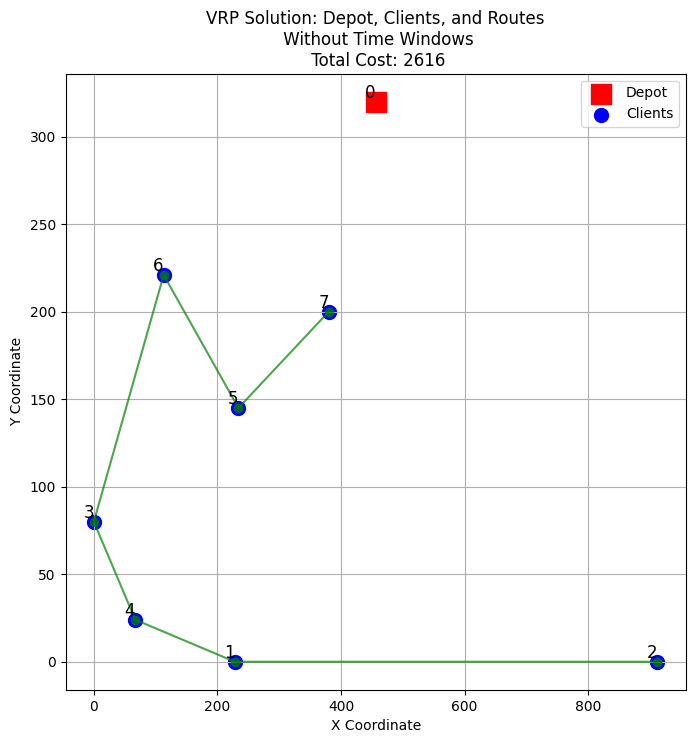

In [88]:
# Extract coordinates
x_coords, y_coords = zip(*COORDS)

# Plot depot and clients
plt.figure(figsize=(8, 8))
plt.scatter(x_coords[0], y_coords[0], c='red', marker='s', s=200, label="Depot")  # Depot in red square
plt.scatter(x_coords[1:], y_coords[1:], c='blue', marker='o', s=100, label="Clients")  # Clients in blue circles

# Annotate points with their index
for idx, (x, y) in enumerate(COORDS):
    plt.text(x, y, str(idx), fontsize=12, ha='right', va='bottom', color="black")

# Plot routes
for route in Routes_2:
    route_coords = [COORDS[loc] for loc in route]
    x_route, y_route = zip(*route_coords)
    plt.plot(x_route, y_route, linestyle='-', marker='o', color='green', alpha=0.7)

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.title(f"VRP Solution: Depot, Clients, and Routes\n Without Time Windows\n Total Cost: {Cost_2}")
plt.grid(True)
plt.show()


In [89]:
def proportional_cost_pricing(total_cost_without_time_windows, d):
    total_d = sum(d)
    return [total_cost_without_time_windows * (i / total_d) for i in d]


In [90]:
print(proportional_cost_pricing(Cost_, d))
print(proportional_cost_pricing(Cost_2, d))

[553.5679144385026, 783.8844919786096, 703.0716577540107, 691.9598930481284, 401.0336898395722, 446.4909090909091, 197.9914438502674]
[383.30695187165776, 542.7850267379679, 486.827807486631, 479.13368983957224, 277.68770053475936, 309.1636363636364, 137.0951871657754]


In [91]:
def shapley_value_TW(time_windows):
    n = len(COORDS) -1
    shapley_alloc = {i: 0 for i in customers}
    for i in customers:
        subsets = all_subsets(customers - {i})
        for S in subsets:
            weight = math.factorial(len(S)) * math.factorial(n - len(S) - 1) / math.factorial(n)
            marginal = coalition_cost(time_windows,sorted(S.union({i}))) - coalition_cost(time_windows,S)
            shapley_alloc[i] += weight * marginal
    return shapley_alloc

[553.5679144385026, 783.8844919786096, 703.0716577540107, 691.9598930481284, 401.0336898395722, 446.4909090909091, 197.9914438502674]

In [ ]:
def approximate_shapley_TW(time_windows, num_samples):
    
    n = len(COORDS) - 1  # Number of customers (excluding depot)
    shapley_alloc = [0] * (n + 1)  # List initialized with zeros (size n+1 to match indices)

    for _ in range(num_samples):
        # Generate a random permutation of customers
        perm = np.random.permutation(list(customers))
        coalition = set()

        for i in perm:
            old_cost = coalition_cost(time_windows, sorted(coalition))
            coalition.add(i)
            new_cost = coalition_cost(time_windows, sorted(coalition))
            marginal_contribution = new_cost - old_cost
            
            shapley_alloc[i] += marginal_contribution

    # Normalize by the number of samples
    for i in customers:
        shapley_alloc[i] /= num_samples

    return shapley_alloc[1:]  # Remove depot (index 0)

[114.8, 180.0, 281.6, 288.8, 77.2, 190.8, 28.8]


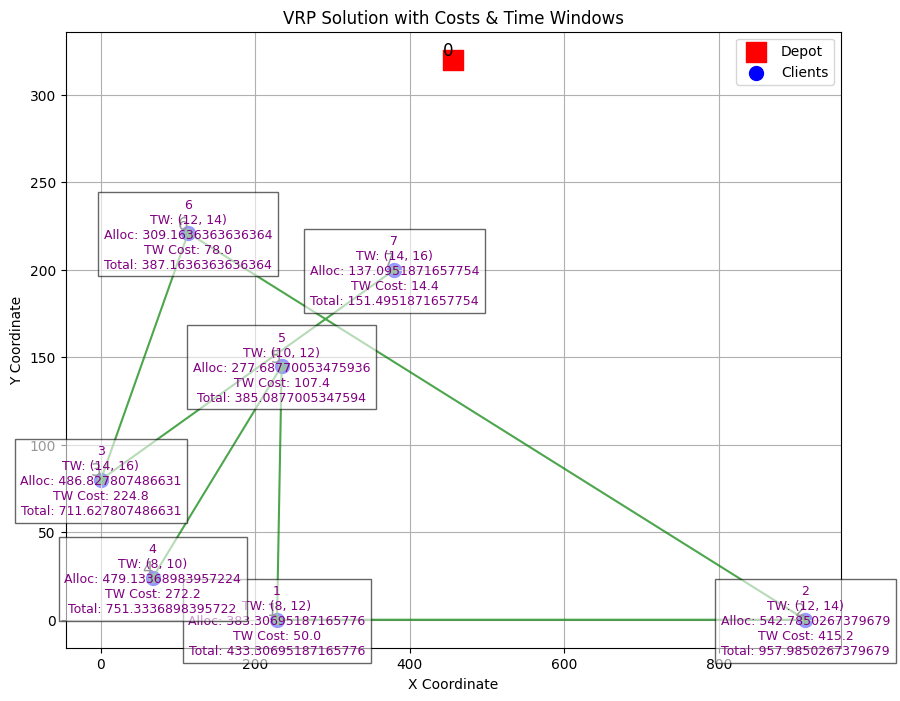

In [95]:


# Sample lists (replace these with your actual data)
allocated_costs = proportional_cost_pricing(Cost_2, d)  # List of allocated costs per customer (without time window)
time_window_costs = approximate_shapley_TW(TIME_WINDOWS, 10)  # List of time window costs per customer
total_allocated_costs = [a+b for a,b in zip(allocated_costs, time_window_costs)]  # List of total allocated costs per customer

# Extract coordinates
x_coords, y_coords = zip(*COORDS)

# Create a figure
plt.figure(figsize=(10, 8))

# Plot depot
plt.scatter(x_coords[0], y_coords[0], c='red', marker='s', s=200, label="Depot")  

# Plot clients
plt.scatter(x_coords[1:], y_coords[1:], c='blue', marker='o', s=100, label="Clients")  

# Annotate depot and clients
for idx, (x, y) in enumerate(COORDS):
    plt.text(x, y, str(idx), fontsize=12, ha='right', va='bottom', color="black")

# Plot routes
for route in Routes_:
    route_coords = [COORDS[loc] for loc in route]
    x_route, y_route = zip(*route_coords)
    plt.plot(x_route, y_route, linestyle='-', marker='o', color='green', alpha=0.7)

# Annotate time windows and costs for each client
for idx, (x, y) in enumerate(COORDS[1:], start=1):
    tw = TIME_WINDOWS[idx]
    allocated_cost = allocated_costs[idx - 1]
    tw_cost = time_window_costs[idx - 1]
    total_cost = total_allocated_costs[idx - 1]

    plt.text(x, y - 20, f"{idx}\nTW: {tw}\nAlloc: {allocated_cost}\nTW Cost: {tw_cost}\nTotal: {total_cost}", 
             fontsize=9, ha='center', color='purple', bbox=dict(facecolor='white', alpha=0.6))

# Final plot details
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.title("VRP Solution with Costs & Time Windows")
plt.grid(True)
plt.show()
